## Assignment 4 - Data Preprocessing and feature engineering-Phase 1

In [31]:
import pandas as pd

df = pd.read_csv('wdbc.data', header=None)
df.columns = [
    'id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
    'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
    'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
    'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst',
    'fractal_dimension_worst'
]

# Display the first few rows of the dataset
print(df.head())


import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.neighbors import LocalOutlierFactor


# Display the first few rows of the dataset
print(df.head())

# Display the structure of the dataset
print(df.info())

# Display basic statistical details
print(df.describe())


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

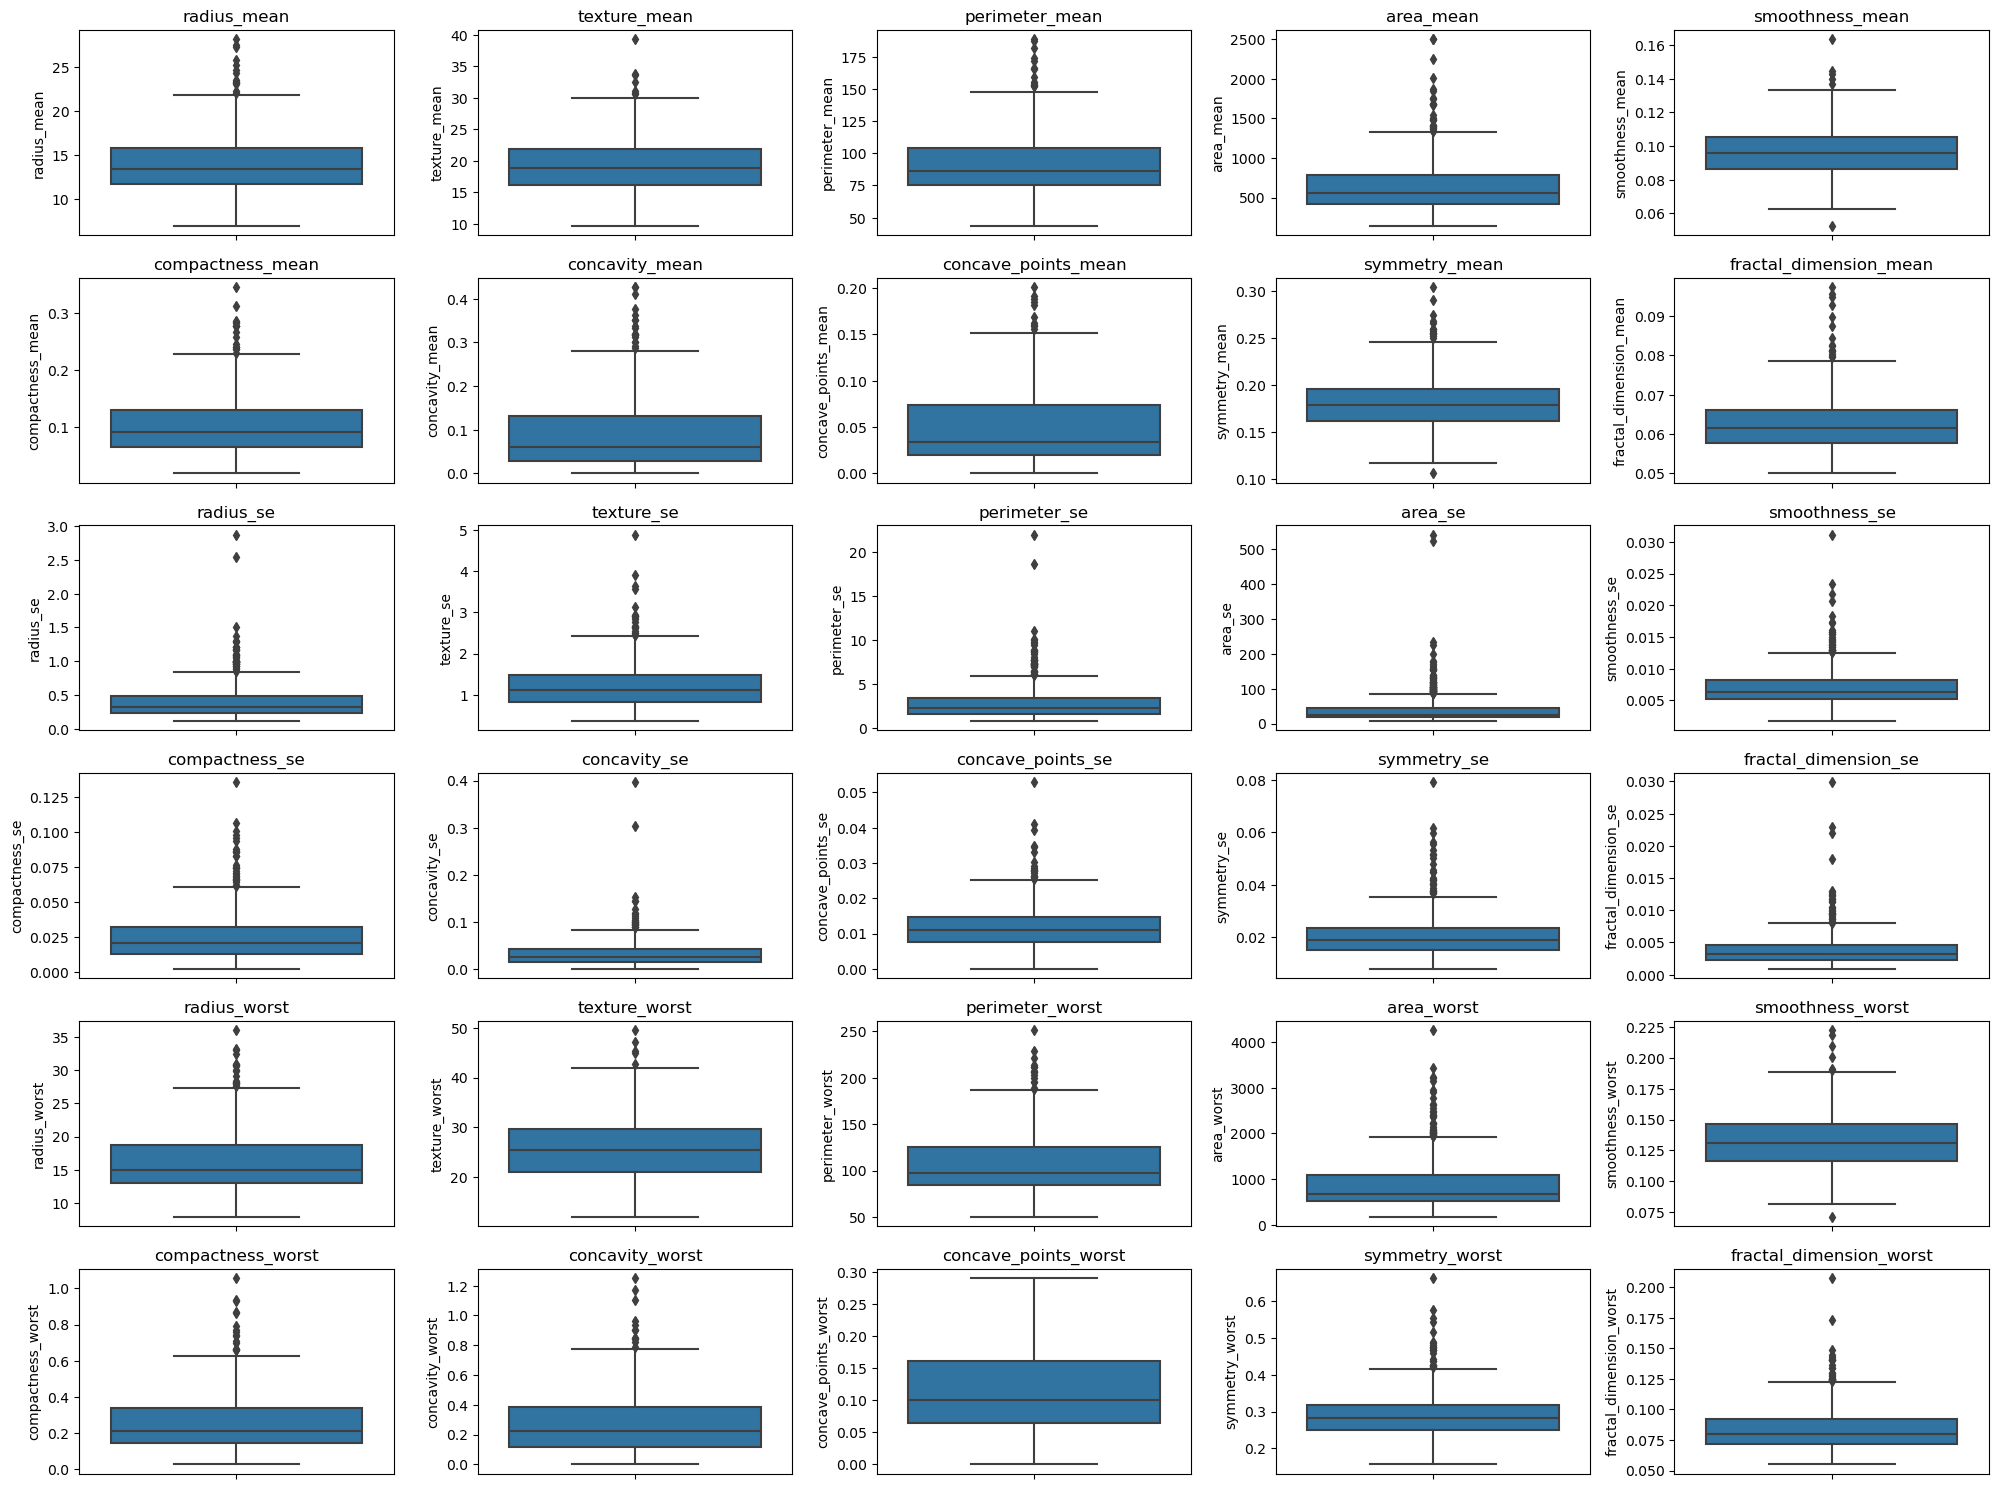

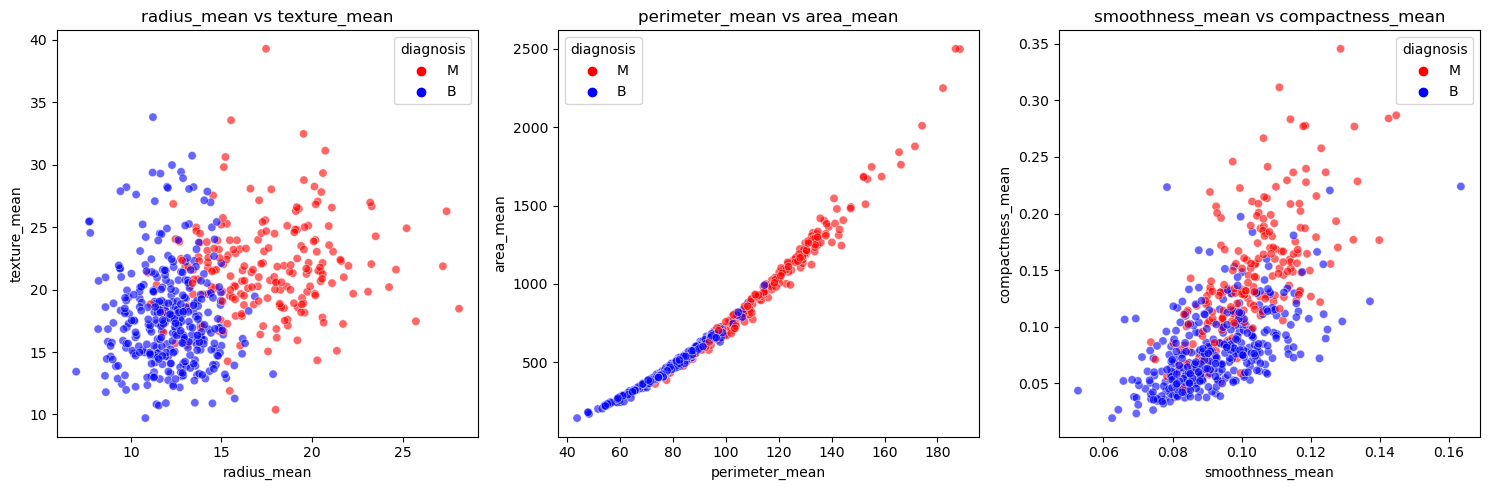

In [33]:

# Remove the 'id' column as it is not needed for analysis
df = df.drop(columns=['id'])

# 1. Boxplots for Each Feature
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns[1:], 1):
    plt.subplot(6, 5, i)
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

# 2. Scatter Plots for Pairwise Features
# For simplicity, let's consider only a few pairs of features
pairs = [('radius_mean', 'texture_mean'), ('perimeter_mean', 'area_mean'), ('smoothness_mean', 'compactness_mean')]

plt.figure(figsize=(15, 5))
for i, (x, y) in enumerate(pairs, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=df[x], y=df[y], hue=df['diagnosis'], palette=['red', 'blue'], alpha=0.6)
    plt.title(f'{x} vs {y}')
    plt.xlabel(x)
    plt.ylabel(y)
plt.tight_layout()
plt.show()


In [11]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtype != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtype == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != "O" and col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

# Remove 'id' and 'Unnamed: 32' from numerical columns as they are irrelevant
num_cols.remove('id')
if 'Unnamed: 32' in num_cols:
    num_cols.remove('Unnamed: 32')

print(num_cols)


Observations: 569
Variables: 32
cat_cols: 1
num_cols: 31
cat_but_car: 0
num_but_cat: 0
['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']


In [13]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# Check for outliers in numerical columns
for col in num_cols:
    print(col, check_outlier(df, col))

# Function to replace outliers with thresholds
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# Replace outliers with threshold values
for col in num_cols:
    replace_with_thresholds(df, col)

# Verify that there are no more outliers
for col in num_cols:
    print(col, check_outlier(df, col))


radius_mean True
texture_mean True
perimeter_mean True
area_mean True
smoothness_mean True
compactness_mean True
concavity_mean True
concave_points_mean True
symmetry_mean True
fractal_dimension_mean True
radius_se True
texture_se True
perimeter_se True
area_se True
smoothness_se True
compactness_se True
concavity_se True
concave_points_se True
symmetry_se True
fractal_dimension_se True
radius_worst True
texture_worst True
perimeter_worst True
area_worst True
smoothness_worst True
compactness_worst True
concavity_worst True
concave_points_worst False
symmetry_worst True
fractal_dimension_worst True
radius_mean False
texture_mean False
perimeter_mean False
area_mean False
smoothness_mean False
compactness_mean False
concavity_mean False
concave_points_mean False
symmetry_mean False
fractal_dimension_mean False
radius_se False
texture_se False
perimeter_se False
area_se False
smoothness_se False
compactness_se False
concavity_se False
concave_points_se False
symmetry_se False
fractal_dim

In [15]:
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Verify the scaling
print(df.head())


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M     0.737918      0.032627        0.761873   0.724975   
1    842517         M     0.910852      0.392501        0.859264   0.999746   
2  84300903         M     0.851867      0.561967        0.831300   0.895756   
3  84348301         M     0.297540      0.519601        0.325828   0.205107   
4  84358402         M     0.892084      0.225469        0.880478   0.975228   

   smoothness_mean  compactness_mean  concavity_mean  concave_points_mean  \
0         0.798006          1.000000        1.000000             0.951888   
1         0.353473          0.283215        0.307709             0.454072   
2         0.681788          0.671573        0.698984             0.827644   
3         1.000000          1.000000        0.854786             0.680752   
4         0.558967          0.542057        0.701108             0.674928   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

In [17]:
from sklearn.model_selection import train_test_split

# Split the dataset
X = df.drop(['diagnosis'], axis=1)
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(455, 31) (114, 31) (455,) (114,)


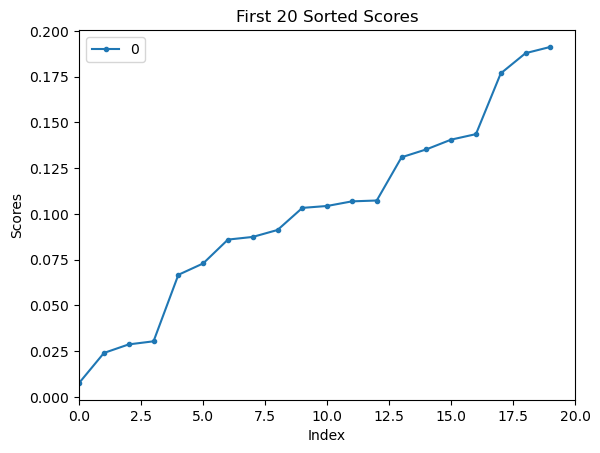

In [43]:
# Visualize the dataset after removing/stabilizing outliers

df_scores = np.random.rand(len(X_test))

scores = pd.DataFrame(np.sort(df_scores)[:20])
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.xlabel('Index')
plt.ylabel('Scores')
plt.title('First 20 Sorted Scores')
plt.show()